# 2D prediction for one hole Kevitsa

In [65]:
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
import torch.optim as optim
import torchbnn as bnn
import numpy as np 
import pandas as pd 
from scipy import linalg
import matplotlib.pyplot as plt

In [66]:
two_composite_filtered = pd.read_csv("Curated_data/two_composite_filtered.csv", low_memory=False)


C:\Users\23478671\AppData\Local\Temp\ipykernel_27244\604552051.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hole_data[columns_to_normalize] = scaler.fit_transform(hole_data[columns_to_normalize])


- Iteration 0, MSE : 0.51
- Iteration 100, MSE : 0.01
- Iteration 200, MSE : 0.01
- Iteration 300, MSE : 0.01
- Iteration 400, MSE : 0.01
- Iteration 500, MSE : 0.01
- Iteration 600, MSE : 0.01
- Iteration 700, MSE : 0.01
- Iteration 800, MSE : 0.01
- Iteration 900, MSE : 0.01
- Iteration 1000, MSE : 0.01
- Iteration 1100, MSE : 0.01
- Iteration 1200, MSE : 0.01
- Iteration 1300, MSE : 0.01
- Iteration 1400, MSE : 0.01
- Iteration 1500, MSE : 0.01
- Iteration 1600, MSE : 0.01
- Iteration 1700, MSE : 0.01
- Iteration 1800, MSE : 0.01
- Iteration 1900, MSE : 0.01
- Iteration 2000, MSE : 0.01
- Iteration 2100, MSE : 0.01
- Iteration 2200, MSE : 0.01
- Iteration 2300, MSE : 0.01
- Iteration 2400, MSE : 0.01
- Iteration 2500, MSE : 0.01
- Iteration 2600, MSE : 0.01
- Iteration 2700, MSE : 0.01
- Iteration 2800, MSE : 0.01
- Iteration 2900, MSE : 0.01
- Iteration 3000, MSE : 0.01
- Iteration 3100, MSE : 0.01
- Iteration 3200, MSE : 0.01
- Iteration 3300, MSE : 0.00
- Iteration 3400, MSE : 0.

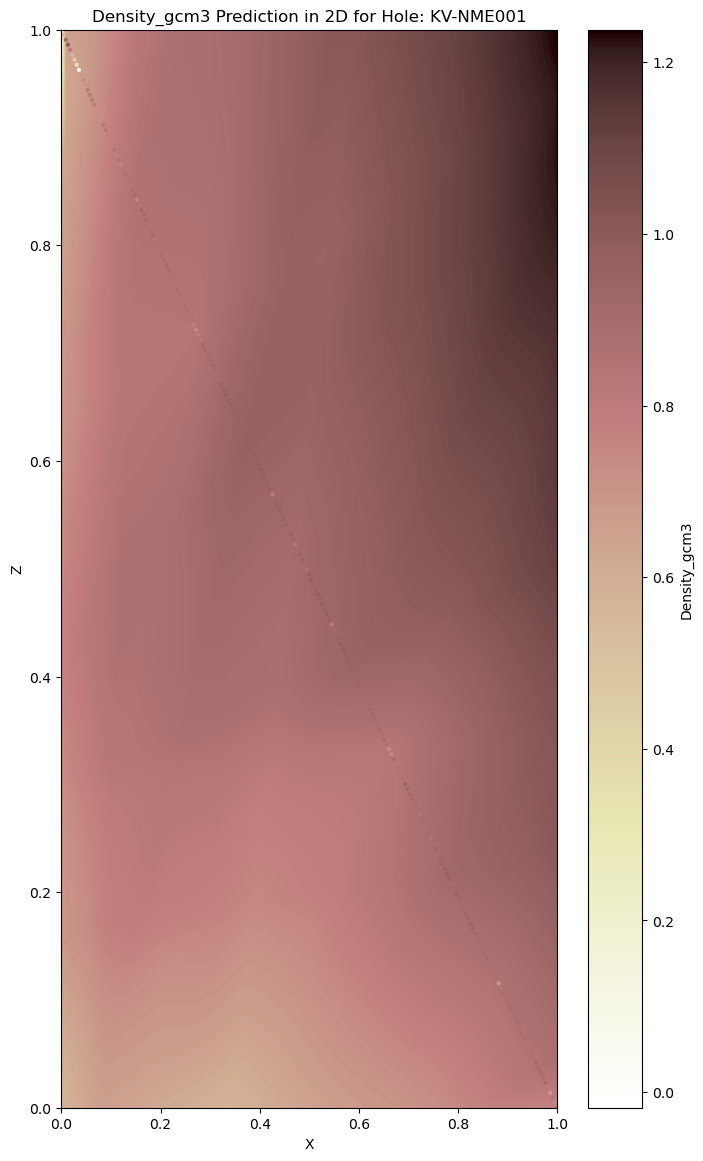

In [67]:
#Subset data for each mineral
mineral = 'Density_gcm3'
two_composite_filtered = two_composite_filtered.loc[:,["Name", 'X', 'Y', 'Z', mineral]]
two_composite_1mineral = two_composite_filtered.dropna(subset=[mineral])


# Define the specific hole you want to predict for
hole_name = 'KV-NME001'


# Filter the data for the selected hole
hole_data = two_composite_1mineral[two_composite_1mineral['Name'] == hole_name]


# Create a MinMaxScaler instance
scaler = MinMaxScaler()

# Define the columns to normalize
columns_to_normalize = ['X','Y', 'Z', mineral]  # Add all columns you want to normalize

# Fit the scaler to your data and transform the specified columns
hole_data[columns_to_normalize] = scaler.fit_transform(hole_data[columns_to_normalize])


# Extract the features (X and Y coordinates) and target (mineral) for the selected hole
x_hole = hole_data[['X', 'Z']].values
y_hole = hole_data[mineral].values[:, np.newaxis]

x_hole = torch.tensor(x_hole)
y_hole = torch.tensor(y_hole)
x_hole = x_hole.to(torch.float32)
y_hole = y_hole.to(torch.float32)

# Create a model for this specific hole
model_hole = nn.Sequential(
    nn.Linear(in_features=2, out_features=200),
    nn.ReLU(),
    nn.Linear(in_features=200, out_features=1)
)

mse_loss = nn.MSELoss()
optimizer = optim.Adam(model_hole.parameters(), lr=0.01)

for step in range(5000):
    pre = model_hole(x_hole)
    mse = mse_loss(pre, y_hole)
    cost = mse

    optimizer.zero_grad()
    cost.backward()
    optimizer.step()

    if step % 100 == 0:
        print('- Iteration %d, MSE : %2.2f' % (step, mse.item()))

# Define a grid of points for prediction
x_grid_hole = np.linspace(x_hole[:, 0].min(), x_hole[:, 0].max(), 100)
y_grid_hole = np.linspace(x_hole[:, 1].min(), x_hole[:, 1].max(), 100)
xv_hole, yv_hole = np.meshgrid(x_grid_hole, y_grid_hole)
xy_grid_hole = np.c_[xv_hole.ravel(), yv_hole.ravel()]

# Make predictions for the grid
predictions_hole = model_hole(torch.tensor(xy_grid_hole, dtype=torch.float32))

# Reshape the predictions to match the grid shape
predictions_hole = predictions_hole.data.numpy().reshape(xv_hole.shape)

import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable

# Pool the values from predictions_hole and y_hole
pooled_values = np.concatenate([predictions_hole.ravel(), y_hole.data.numpy()[:, 0]])

# Determine the minimum and maximum values for the color mapping
vmin = np.min(pooled_values)
vmax = np.max(pooled_values)

# Create a ScalarMappable for both plots using the same criteria
sm = ScalarMappable(cmap='pink_r')
sm.set_array([])  # Set an empty array to enforce the same vmin and vmax
sm.set_clim(vmin, vmax)  # Set the same vmin and vmax

plt.figure(figsize=(8, 14))

contour_hole = plt.contourf(xv_hole, yv_hole, predictions_hole, cmap='pink_r', vmin=vmin, vmax=vmax, levels=500)  # Adjust levels as needed
scatter = plt.scatter(x_hole.data.numpy()[:, 0], x_hole.data.numpy()[:, 1], c=y_hole.data.numpy(), cmap='pink_r', vmin=vmin, vmax=vmax, s=4, label='Selected Hole Data')

# Optionally, you can scatter plot the data points for this specific hole

# Add a colorbar associated with both plots
cb = plt.colorbar(sm, label=mineral)

# Set the color mapping based on the scatter plot

plt.xlabel('X')
plt.ylabel('Z')
plt.title(f'{mineral} Prediction in 2D for Hole: {hole_name}')
plt.show()


In [ ]:
import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable
import numpy as np

# Pool the values from predictions_hole and y_hole
pooled_values = np.concatenate([predictions_hole.ravel(), y_hole.data.numpy()[:, 0]])

# Determine the minimum and maximum values for the color mapping
vmin = np.min(pooled_values)
vmax = np.max(pooled_values)

# Create a ScalarMappable for both plots using the same criteria
sm = ScalarMappable(cmap='pink_r', norm=plt.Normalize(vmin=vmin, vmax=vmax))

# Get the minimum and maximum values for the axes
x_min = min(xv_hole.min(), x_hole.data.numpy()[:, 0].min())
x_max = max(xv_hole.max(), x_hole.data.numpy()[:, 0].max())
y_min = min(yv_hole.min(), x_hole.data.numpy()[:, 1].min())
y_max = max(yv_hole.max(), x_hole.data.numpy()[:, 1].max())

# Create the first plot for the contour
plt.figure(figsize=(14, 7))
plt.subplot(121)  # Create a subplot with 1 row and 2 columns, this is the first plot
contour_hole = plt.contourf(xv_hole, yv_hole, predictions_hole, cmap='pink_r', vmin=vmin, vmax=vmax, levels=100, extent=[x_min, x_max, y_min, y_max])  # Set the extent
plt.colorbar(sm, label=f'{mineral}')
plt.xlabel('X')
plt.ylabel('Z')
plt.title(f'{mineral} Prediction in 2D for Hole: {hole_name} (Contour)')

# Create the second plot for the scatter
plt.subplot(122)  # This is the second plot
scatter = plt.scatter(x_hole.data.numpy()[:, 0], x_hole.data.numpy()[:, 1], c=y_hole.data.numpy(), cmap='pink_r', vmin=vmin, vmax=vmax, s=4, label='Selected Hole Data')
plt.colorbar(sm, label=f'{mineral}')
plt.xlim(x_min, x_max)  # Set the same limits as the contour plot
plt.ylim(y_min, y_max)  # Set the same limits as the contour plot
plt.xlabel('X')
plt.ylabel('Z')
plt.title(f'{mineral} Prediction in 2D for Hole: {hole_name} (Scatter)')



plt.tight_layout()  # Ensures plots don't overlap
plt.show()


In [ ]:
for hole_name in two_composite_filtered['Name'].unique():
    #Subset data for each mineral
    mineral = 'Density_gcm3'
    two_composite_filtered = two_composite_filtered.loc[:,["Name", 'X', 'Y', 'Z', mineral]]
    two_composite_1mineral = two_composite_filtered.dropna(subset=[mineral])

    # Define the specific hole you want to predict for
    hole_name = 'KV-NME001'

    # Filter the data for the selected hole
    hole_data = two_composite_1mineral[two_composite_1mineral['Name'] == hole_name]


    # Create a MinMaxScaler instance
    scaler = MinMaxScaler()

    # Define the columns to normalize
    columns_to_normalize = ['X','Y', 'Z', mineral]  # Add all columns you want to normalize

    # Fit the scaler to your data and transform the specified columns
    hole_data[columns_to_normalize] = scaler.fit_transform(hole_data[columns_to_normalize])

    # Extract the features (X and Y coordinates) and target (mineral) for the selected hole
    x_hole = hole_data[['X', 'Z']].values
    y_hole = hole_data[mineral].values[:, np.newaxis]

    x_hole = torch.tensor(x_hole)
    y_hole = torch.tensor(y_hole)
    x_hole = x_hole.to(torch.float32)
    y_hole = y_hole.to(torch.float32)

    # Create a model for this specific hole
    model_hole = nn.Sequential(
        nn.Linear(in_features=2, out_features=200),
        nn.ReLU(),
        nn.Linear(in_features=200, out_features=1)
    )

    mse_loss = nn.MSELoss()
    optimizer = optim.Adam(model_hole.parameters(), lr=0.01)

    for step in range(5001):
        pre = model_hole(x_hole)
        mse = mse_loss(pre, y_hole)
        cost = mse

        optimizer.zero_grad()
        cost.backward()
        optimizer.step()

        if step % 100 == 0:
            print('- Iteration %d, MSE : %2.2f' % (step, mse.item()))

    # Define a grid of points for prediction
    x_grid_hole = np.linspace(x_hole[:, 0].min(), x_hole[:, 0].max(), 100)
    y_grid_hole = np.linspace(x_hole[:, 1].min(), x_hole[:, 1].max(), 100)
    xv_hole, yv_hole = np.meshgrid(x_grid_hole, y_grid_hole)
    xy_grid_hole = np.c_[xv_hole.ravel(), yv_hole.ravel()]

    # Make predictions for the grid
    predictions_hole = model_hole(torch.tensor(xy_grid_hole, dtype=torch.float32))

    # Reshape the predictions to match the grid shape
    predictions_hole = predictions_hole.data.numpy().reshape(xv_hole.shape)

    # Pool the values from predictions_hole and y_hole
    pooled_values = np.concatenate([predictions_hole.ravel(), y_hole.data.numpy()[:, 0]])

    # Determine the minimum and maximum values for the color mapping
    vmin = np.min(pooled_values)
    vmax = np.max(pooled_values)

    # Create a ScalarMappable for both plots using the same criteria
    sm = ScalarMappable(cmap='pink_r', norm=plt.Normalize(vmin=vmin, vmax=vmax))

    plt.figure(figsize=(8, 14))

    contour_hole = plt.contourf(xv_hole, yv_hole, predictions_hole, cmap='pink_r', vmin=vmin, vmax=vmax, levels=500)  # Adjust levels as needed
    scatter = plt.scatter(x_hole.data.numpy()[:, 0], x_hole.data.numpy()[:, 1], c=y_hole.data.numpy(), cmap='pink_r', vmin=vmin, vmax=vmax, s=4, label='Selected Hole Data')

    # Optionally, you can scatter plot the data points for this specific hole

    # Add a colorbar associated with both plots
    cb = plt.colorbar(sm, label=mineral)

    # Set the color mapping based on the scatter plot

    plt.xlabel('X')
    plt.ylabel('Z')
    plt.title(f'{mineral} Prediction in 2D for Hole: {hole_name}')
    plt.show()